# STDP, 'online'

Demonstrates all aspects of the online STDPLearningRule.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

from spikeflow import firing_to_spike_process, firings_to_spike_processes
from spikeflow import spike_process_delta_times
from spikeflow import STDPParams, STDP_Tracer, STDPLearningRule, WeightBounds
from spikeflow import IdentityNeuronLayer, Synapse, ComplexSynapseLayer, weights_from_synapses
from spikeflow import BPNNModel
from spikeflow.drawing_utils.trace_renderers import STDPTracesRenderer, IdentityNeuronTraceRenderer, render_figure

/Applications/Anaconda/anaconda/envs/mlbook/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**Some helpful functions; ignore for now:**

In [3]:
def get_single_firings_at(fire_ats, t):
    r = np.zeros(t, dtype=int)
    for fa in fire_ats:
        r[fa] = 1
    return r.T

def get_input_firings(number_input_neurons, interval, t):
    firings_ats = [i for i in range(0, t, interval) if i > 2 and i < t]
    #input_firings = [get_input_firing(firings_ats, t) for n in range(number_input_neurons)]
    input_firings = [get_single_firings_at(
        [i for i in range(interval*n, t, interval) if i > 2 and i < t]
        , t) for n in range(number_input_neurons)]
    return np.array(input_firings).T

def get_output_firings(num_neurons, timesteps):
    r = np.zeros((timesteps, num_neurons), dtype=int)
    for n in range(num_neurons):
        interval = timesteps // (num_neurons+1)
        t = n * interval + interval
        r[t, n] = 1
    return r

def get_W(num_input_neurons, num_output_neurons):
    return np.ones((num_input_neurons, num_output_neurons), dtype=np.float32)

def firing_indexes(firings):
    inds = []
    for input_firing in firings.T:
        inds = inds + [t for t, i in enumerate(input_firing) if i == 1]
    return inds

def display_traces(input_firings, input_traces, output_firings, output_traces, dw=None):
    ni = len(input_firings[0])
    no = len(output_firings[0])
    nt = len(input_firings)
    
    input_colormap = plt.cm.spring 
    output_colormap = plt.cm.nipy_spectral 

    fig = plt.figure(num=None, figsize=(16, 4 if dw is None else 7), dpi=100.0)
    gs = gridspec.GridSpec(4 if dw is None else 6, 1, hspace=1.2, height_ratios=[1, 2, 1, 2] + ([1, 4] if dw is not None else []))
    
    def show_firings(firings, subplotindex, title, colors):
        ax = fig.add_subplot(gs[subplotindex])
        ax.set_title(title)
        ax.set_xlim(-1, nt)
        plt.xticks([])
        plt.yticks([])
        plt.box(on=None)
        ax.vlines(firing_indexes(firings), ymin=0, ymax=1, colors=colors)
        for i,j in enumerate(ax.lines):
            j.set_color(colors[i])
        
    def show_traces(traces, subplotindex, title, colors, xticks=False):
        ax = fig.add_subplot(gs[subplotindex])
        ax.set_title(title)
        ax.set_xlim(-1, nt)
        ax.xaxis.grid(which="major", color='#ffffff', linestyle='--', linewidth=1)
        plt.box(on=None)
        if not xticks:
            plt.xticks([])
        else:
            plt.xlabel('time')
        ax.yaxis.grid(which="major", color='grey', linestyle='--', linewidth=1)
        ax.plot(traces, 'o--', linewidth=1, markersize=4)
        ax.grid(True)
        for i,j in enumerate(ax.lines):
            j.set_color(colors[i])
            
    def show_dw(dw, subplotindex, colors):
        ax = fig.add_subplot(gs[subplotindex])
        ax.set_title(r'$dW_j$')
        ax.set_xlim(-(nt // 2) - 1, nt // 2 + 1)
        miny = np.min(dw)
        if miny < 0:
            plt.yticks([miny, 0, np.max(dw)])
        else:
            plt.yticks([0, np.max(dw)])
        plt.box(on=None)
        ax.grid(True)
        plt.ylabel('dW')
        plt.xlabel(r'$t_{post} - t_{pre}$')
        n = len(dw[0])
        ax.plot([i-(n//2) for i in range(n)], dw[0], 'o--', linewidth=1, markersize=4)
            
    colors = [input_colormap(i) for i in np.linspace(0, 1,ni)]
    show_firings(input_firings, 0, 'input firings', colors)
    show_traces(input_traces, 1, 'input traces', colors)
    
    colors = [output_colormap(i) for i in np.linspace(0, 1, no)]
    show_firings(output_firings, 2, 'output firings', colors)
    show_traces(output_traces, 3, 'output Traces', colors, xticks=True)
    if dw is not None:
        show_dw(dw, 5, colors)
    
    plt.show()
    
def display_final_Ws(t, final_Ws, title):
    output_colormap = plt.cm.nipy_spectral 
    colors = [output_colormap(i) for i in np.linspace(0, 1, t)]

    fig = plt.figure(num=None, figsize=(16, 3), dpi=100.0)
    gs = gridspec.GridSpec(1, 1, hspace=1.2, height_ratios=[1])

    ax = fig.add_subplot(gs[0])
    ax.set_title(title)
    plt.xticks(list(range(final_Ws.shape[0])))
    ax.xaxis.grid(which="major", color='#ffffff', linestyle='--', linewidth=1)
    plt.box(on=None)
    plt.xlabel('repetitions')
    plt.ylabel(r'$W_j$')
    ax.yaxis.grid(which="major", color='grey', linestyle='--', linewidth=1)
    ax.plot(final_Ws, 'o--', linewidth=1, markersize=4)
    ax.grid(True)
    for i,j in enumerate(ax.lines):
        j.set_color(colors[i])
        
    plt.show()

# Demonstrate stdp tracing

** Very simple: **

STDPParams A+:1.00 A-:2.00 T+:1.40 T-:2.00


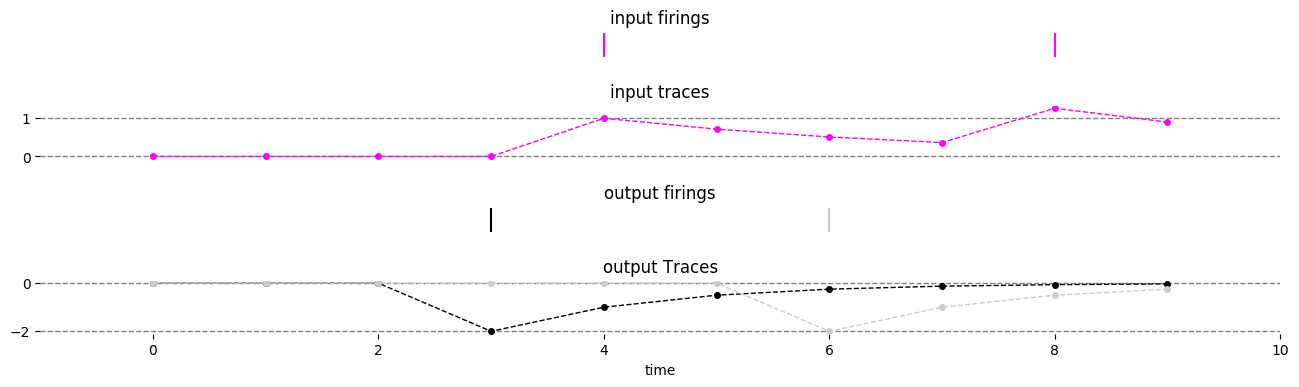

In [4]:
firings_input = get_input_firings(1, 4, 10)
firings_output = get_output_firings(2, 10)
W = get_W(1, 2)

stdp_params = STDPParams(APlus=1.0, AMinus=2.0, TauPlus=1.4, TauMinus=2.0, all_to_all=True)
print(stdp_params)

stdp_tracer = STDP_Tracer(stdp_params)
results = stdp_tracer.test(W, firings_input, firings_output)

display_traces(firings_input, results[0], firings_output, results[1])

** Demonstrate on more data, with all_to_all = False**

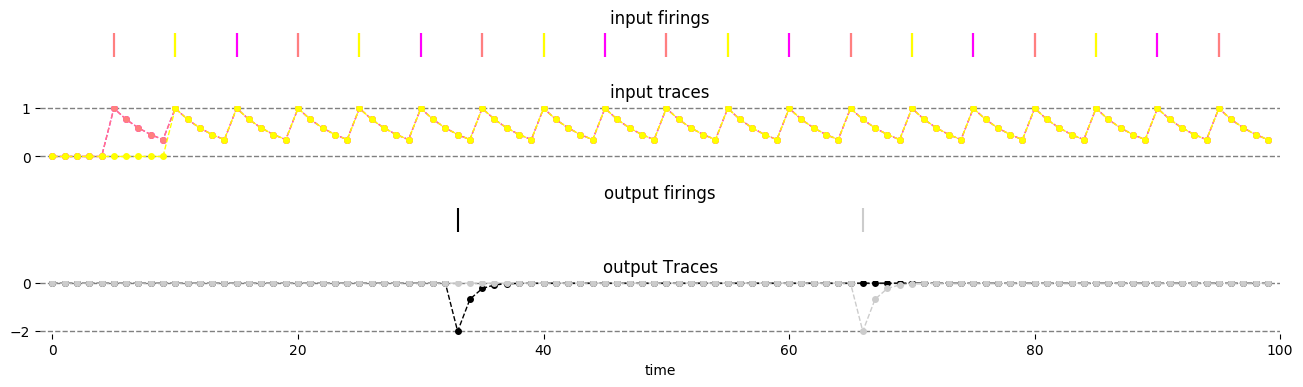

In [5]:
firings_input = get_input_firings(3, 5, 100)
firings_output = get_output_firings(2, 100)
W = get_W(3, 2)

stdp_params = STDPParams(APlus=1.0, AMinus=2.0, TauPlus=1.3, TauMinus=3.0, all_to_all=False)
stdp_tracer = STDP_Tracer(stdp_params)
res = stdp_tracer.test(W, firings_input, firings_output)

display_traces(firings_input, res[0], firings_output, res[1])

** ... now with all_to_all = True **

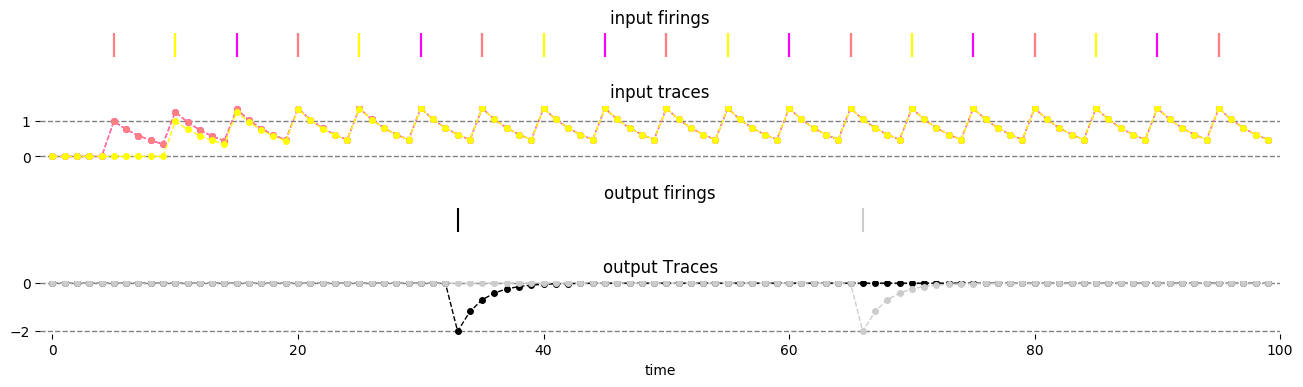

In [6]:
stdp_params = STDPParams(APlus=1.0, AMinus=2.0, TauPlus=1.3, TauMinus=1.7, all_to_all=True)
stdp_tracer = STDP_Tracer(stdp_params)
res = stdp_tracer.test(W, firings_input, firings_output)

display_traces(firings_input, res[0], firings_output, res[1])

** do it with more neurons and 1000 timesteps **

input: (1000, 10)
output: (1000, 30)
W: (10, 30)
STDPParams A+:1.00 A-:2.00 T+:1.20 T-:1.10


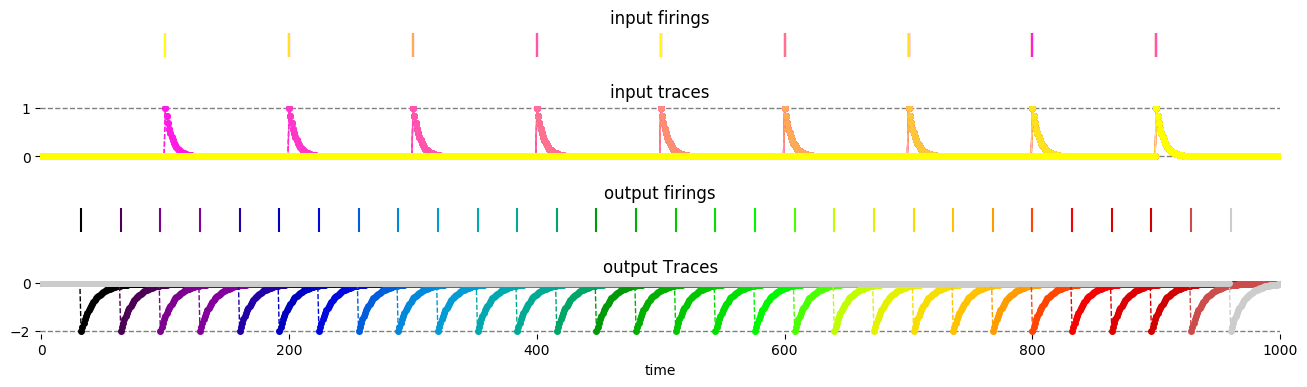

Each color is a different neuron trace!


In [7]:
medium_firings_input = get_input_firings(10, 100, 1000)
medium_firings_output = get_output_firings(30, 1000)
medium_W = get_W(10, 30)

print('input:', medium_firings_input.shape)
print('output:', medium_firings_output.shape)
print('W:', medium_W.shape)

stdp_params_2 = STDPParams(APlus=1.0, AMinus=2.0, TauPlus=1.2, TauMinus=1.1, all_to_all=True)
print(stdp_params_2)

medium_stdp_tracer = STDP_Tracer(stdp_params_2)
res = medium_stdp_tracer.test(medium_W, medium_firings_input, medium_firings_output)

display_traces(medium_firings_input, res[0], medium_firings_output, res[1])

print('Each color is a different neuron trace!')

# Demonstrate STDP dW curve
** Compute total dW from STDP as function of difference between pre- and post- synaptic neuron firing times **

STDPParams A+:1.00 A-:2.00 T+:1.40 T-:1.70
Each color is a different neuron trace:


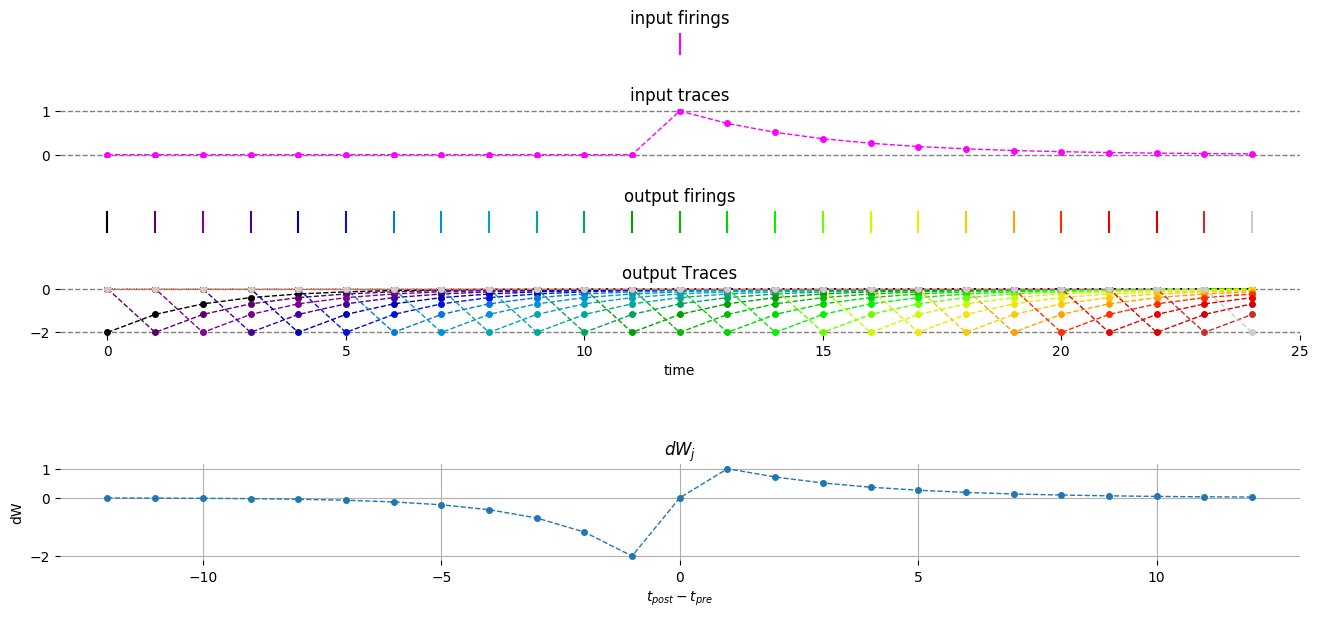

In [8]:
t = 25

firings_input = np.array([get_single_firings_at([t//2], t)]).T
firings_output = np.diag([1]*t)
W = get_W(1, t) * 0.5

stdp_params = STDPParams(APlus=1.0, AMinus=2.0, TauPlus=1.4, TauMinus=1.7, all_to_all=True)
print(stdp_params)
print('Each color is a different neuron trace:')

stdp_tracer = STDP_Tracer(stdp_params)
traces = stdp_tracer.test(W, firings_input, firings_output)

learning_rule = STDPLearningRule('stdp1', stdp_params)
dpre, dpost, assw = learning_rule.test(W, firings_input, firings_output)
tdw = dpre + dpost

display_traces(firings_input, traces[0], firings_output, traces[1], tdw)

# Demonstrate weight bounding:
** W as function of number of repetitions of the above data.**

STDPParams A+:1.00 A-:2.00 T+:1.40 T-:1.70


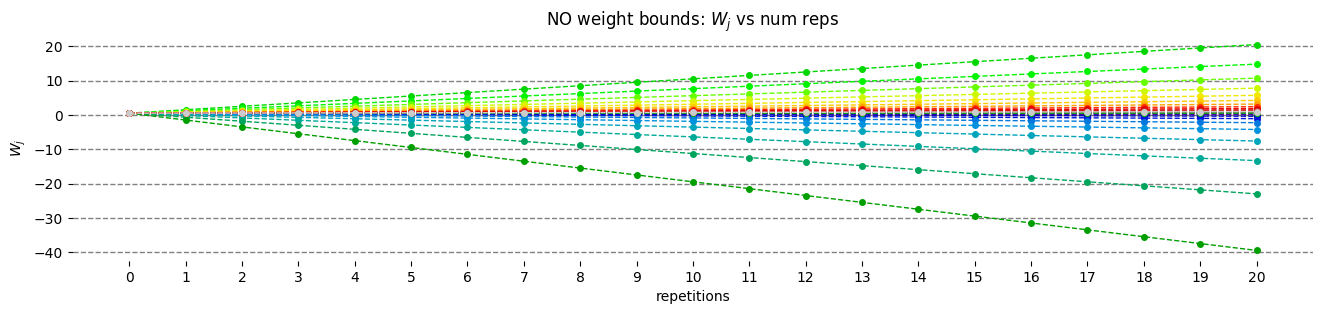

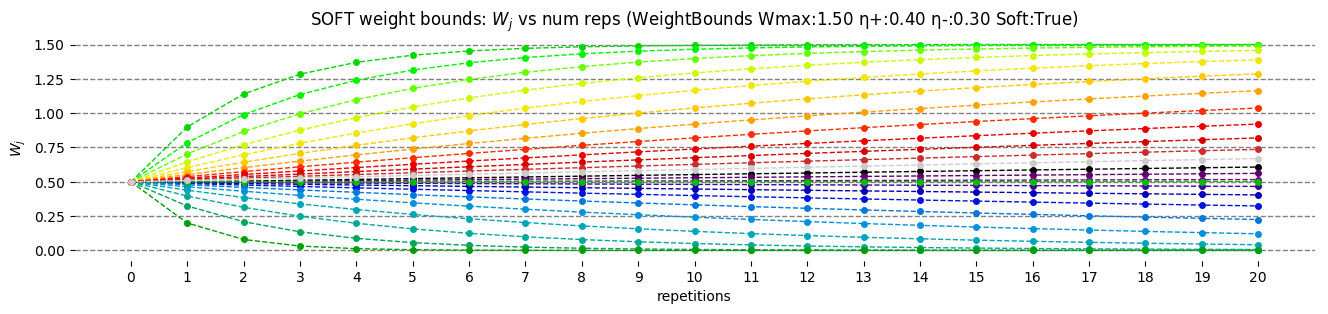

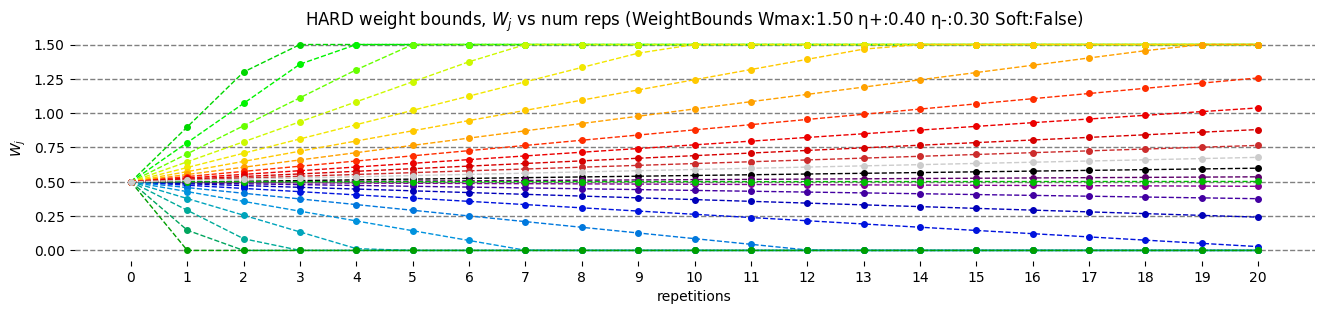

In [9]:
W = get_W(1, t) * 0.5
stdp_params = STDPParams(APlus=1.0, AMinus=2.0, TauPlus=1.4, TauMinus=1.7, all_to_all=True)
print(stdp_params)

steps = 21

# NO bounds
all_w = []
for i in range(steps):
    learning_rule = STDPLearningRule('stdp_no_bounds', stdp_params, weight_bounds=None)
    _, _, assw = learning_rule.test(W, firings_input, firings_output, reps=i)
    all_w.append(assw)
aw = np.array(all_w)
final_Ws = np.reshape(np.array(all_w), (steps, t))
display_final_Ws(t, final_Ws, r'NO weight bounds: $W_j$ vs num reps')

# SOFT bounds
all_w = []
weight_bounds = WeightBounds(WMax=1.5, EtaPlus=0.4, EtaMinus=0.3, Soft=True)
for i in range(steps):
    learning_rule = STDPLearningRule('stdp_soft_bounds', stdp_params, weight_bounds=weight_bounds)
    _, _, assw = learning_rule.test(W, firings_input, firings_output, reps=i)
    all_w.append(assw)
final_Ws = np.reshape(np.array(all_w), (steps, t))
display_final_Ws(t, final_Ws, r'SOFT weight bounds: $W_j$ vs num reps ({})'.format(weight_bounds))

# HARD bounds
all_w = []
weight_bounds = WeightBounds(WMax=1.5, EtaPlus=0.4, EtaMinus=0.3, Soft=False)
for i in range(steps):
    learning_rule = STDPLearningRule('stdp_hard_bounds', stdp_params, weight_bounds=weight_bounds)
    _, _, assw = learning_rule.test(W, firings_input, firings_output, reps=i)
    all_w.append(assw)
final_Ws = np.reshape(np.array(all_w), (steps, t))
display_final_Ws(t, final_Ws, r'HARD weight bounds, $W_j$ vs num reps ({})'.format(weight_bounds))

# We can also do 'Associative' STDP
** Simply set AMinus to None **

STDPParams A+:1.00 T+:1.40 T-:1.40 Associative!


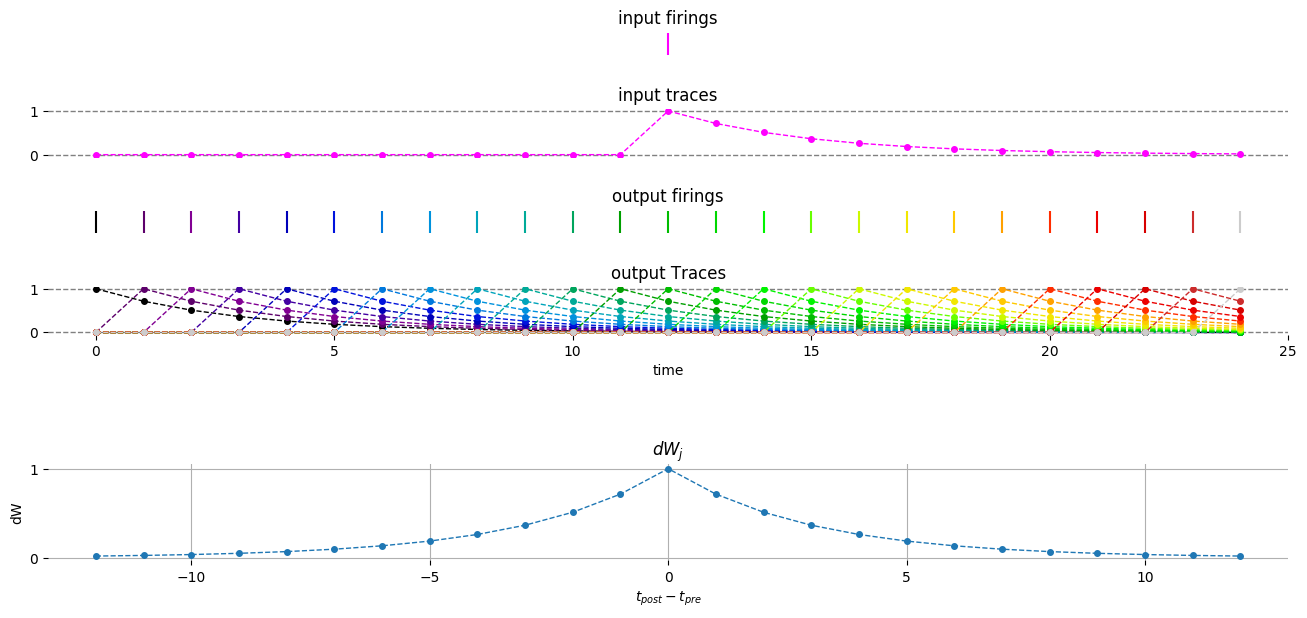

In [10]:
stdp_params = STDPParams(APlus=1.0, AMinus=None, TauPlus=1.4, TauMinus=1.4, all_to_all=True)
print(stdp_params)

stdp_tracer = STDP_Tracer(stdp_params)
traces = stdp_tracer.test(W, firings_input, firings_output)

learning_rule = STDPLearningRule('stdp1', stdp_params)
dpre, dpost, assw = learning_rule.test(W, firings_input, firings_output)
tdw = dpre + dpost

display_traces(firings_input, traces[0], firings_output, traces[1], tdw)

** That's all! See the next example for how to actually embed stdp into a model. **